In [1]:
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import sys

sys.path.append("..")
from src.utils import utils

importlib.reload(utils)
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Exploratory Data Analysis of Pacman gathered data (Updated to 2024-12-30)

In [5]:
## Read tables from csv
BANNED_USERS = [42]

user_df = pd.read_csv("../data/user.csv")
ip_df = pd.read_csv("../data/userip.csv")
redcap_df = pd.read_csv("../data/redcapdata.csv")
game_df = pd.read_csv(
    "../data/game.csv", converters={"date_played": lambda x: pd.to_datetime(x)}
)
game_df = game_df[~game_df["user_id"].isin(BANNED_USERS)]  # Remove user 42 (myself)
# game_df = game_df[game_df['user_id'] != 47]
gamestate_df = pd.read_csv(
    "../data/gamestate.csv", converters={"user_id": lambda x: int(x)}
)
gamestate_df = gamestate_df[
    ~gamestate_df["game_id"].isin(
        game_df.loc[game_df["user_id"].isin(BANNED_USERS), "game_id"]
    )
]  # Remove games associated with userid 42 (myself)
psychometrics_df = pd.read_csv("..\data\psych\AiPerCogPacman_DATA_2025-04-01_1343.csv")

In [6]:
## Inspect data

user_df.info()
game_df.info()
gamestate_df.info()


user_df.head()
game_df.head()
gamestate_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   150 non-null    int64 
 1   username  150 non-null    object
 2   password  150 non-null    object
 3   email     150 non-null    object
dtypes: int64(1), object(3)
memory usage: 4.8+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 855 entries, 4 to 861
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   game_id             855 non-null    int64         
 1   user_id             855 non-null    int64         
 2   session_number      855 non-null    int64         
 3   game_in_session     855 non-null    int64         
 4   total_games_played  855 non-null    int64         
 5   source              855 non-null    object        
 6   date_played         855 non-null    datetime64[ns]
 7   game_dura

,user_id,username,password,email
0,42,Pipa,$2y$10$eaIuKNdOjUqI0pxnZ5nUzu/e2QZS3Dqz2fGL1BO...,2323
1,61,snitch,$2y$10$Q32znpux74Oxo53bntHGZeNo04Y7tUbuXVsX/Ze...,sonja.kilpelainen@helsinki.fi
2,62,bencowley,$2y$10$hZ2z65VxakTGuYjQNVIR0eA9uIs8R4fQhOrATUz...,ben.cowley@helsinki.fi
3,63,Mosh,$2y$10$/1zd0cbvo1otOHkyU56y0.RuxKcc.z0jYBBQ2dr...,satu.sahla@helsinki.fi
4,64,Beñat,$2y$10$qOdTjOy3sdVj8FymDzouA.A2nvjpMfbiqGD5i3i...,betxeber@gmail.com


,game_id,user_id,session_number,game_in_session,total_games_played,source,date_played,game_duration,win,level
4,388,64,1,1,1,DataGathering,2024-11-29 14:13:35,75.874,1,1
5,389,64,1,2,2,DataGathering,2024-11-29 14:14:58,14.981,0,2
6,390,64,1,3,3,DataGathering,2024-11-29 14:15:57,55.516,1,1
7,391,64,1,4,4,DataGathering,2024-11-29 14:17:00,48.834,0,2
8,392,64,1,5,5,DataGathering,2024-11-29 14:18:12,80.657,1,1


,game_state_id,game_id,time_elapsed,score,lives,pacman_attack,input_direction,movement_direction,Pacman_X,Pacman_Y,...,ghost3_state,ghost4_state,powerPellets,pellets,powerpelletstate_1,powerpelletstate_2,powerpelletstate_3,powerpelletstate_4,fruitState_1,fruitState_2
0,214062,382,0.19,0,3,0,NaN,none,0.0,-9.498903,...,0,0,4,244,1,1,1,1,0,0
1,214063,382,0.23,0,3,0,none,none,0.0,-9.498903,...,0,0,4,244,1,1,1,1,0,0
2,214064,382,0.29,0,3,0,none,none,0.0,-9.498903,...,0,0,4,244,1,1,1,1,0,0
3,214065,382,0.33,0,3,0,none,none,0.0,-9.498903,...,0,0,4,244,1,1,1,1,0,0
4,214066,382,0.39,0,3,0,none,none,0.0,-9.498903,...,0,0,4,244,1,1,1,1,0,0


In [7]:
game_df[["game_duration"]].describe()

,game_duration
count,855.000000
mean,58.395628
std,36.623574
min,4.155000
25%,47.114500
50%,59.630000
75%,72.118000
max,933.101000


In [8]:
# Aggregated data per participant
agg = game_df.groupby("user_id").agg(
    {
        "game_duration": "mean",
        "level": "max",
        "game_id": "count",
        "game_in_session": "max",
        "session_number": "max",
        "win": "sum",
    }
)

agg["winrate"] = agg["win"] / agg["game_id"]

agg.rename(
    columns={
        "game_duration": "avg_game_duration",
        "level": "max_level",
        "game_id": "games_played",
        "game_in_session": "longest_session",
        "session_number": "amount_sessions",
        "win": "wins",
    },
    inplace=True,
)

agg.sort_values(by="games_played", ascending=False)

agg.describe()

,avg_game_duration,max_level,games_played,longest_session,amount_sessions,wins,winrate
user_id,,,,,,,
74,62.465310,4,71,23,12,36,0.507042
78,56.279762,3,42,17,5,15,0.357143
73,58.233405,3,37,37,1,15,0.405405
91,51.758030,4,33,33,1,17,0.515152
157,63.527032,4,31,25,2,13,0.419355
...,...,...,...,...,...,...,...
114,65.185000,1,1,1,1,0,0.000000
125,44.623000,1,1,1,1,0,0.000000
170,69.938000,1,1,1,1,0,0.000000


,avg_game_duration,max_level,games_played,longest_session,amount_sessions,wins,winrate
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,60.669812,2.298077,8.221154,6.605769,1.432692,3.519231,0.339834
std,22.767471,1.197731,10.076365,6.641175,1.356498,5.409414,0.260065
min,37.798000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,53.023583,1.000000,3.000000,3.000000,1.000000,0.000000,0.000000
50%,58.248603,2.000000,5.000000,4.000000,1.000000,2.000000,0.387500
75%,63.595399,3.000000,10.000000,6.000000,1.000000,4.000000,0.500000
max,272.720750,5.000000,71.000000,37.000000,12.000000,36.000000,0.800000


(array([33., 27., 14.,  6.,  6.,  3.,  6.,  1.,  0.,  0.,  2.,  0.,  2.,
         1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([ 1.        ,  3.33333333,  5.66666667,  8.        , 10.33333333,
        12.66666667, 15.        , 17.33333333, 19.66666667, 22.        ,
        24.33333333, 26.66666667, 29.        , 31.33333333, 33.66666667,
        36.        , 38.33333333, 40.66666667, 43.        , 45.33333333,
        47.66666667, 50.        , 52.33333333, 54.66666667, 57.        ,
        59.33333333, 61.66666667, 64.        , 66.33333333, 68.66666667,
        71.        ]),
 <BarContainer object of 30 artists>)

Text(0.5, 0, 'Number of Games Played')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Distribution of Games Played per User')

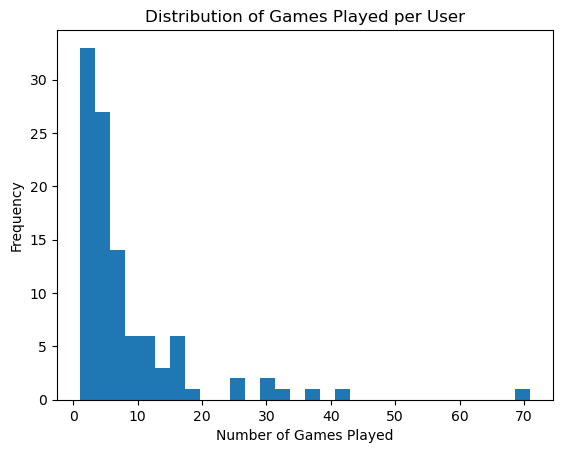

In [9]:
# Descriptive statistic of main variables.

# Distribution of games played per user

user_game_counts = game_df.groupby("user_id").size()
plt.hist(user_game_counts, bins=30)
plt.xlabel("Number of Games Played")
plt.ylabel("Frequency")
plt.title("Distribution of Games Played per User")
plt.show()

In [10]:
game_df.loc[game_df["game_duration"] > 500, "game_id"]

35    419
Name: game_id, dtype: int64

An outlier in game duration was identified. This is game id 419, and it was probably due to a bug (game freeze?).

(array([ 5., 22., 22., 15., 26., 14., 10., 25., 25., 21., 33., 49., 75.,
        67., 77., 69., 61., 76., 45., 43., 31., 10., 15.,  6.,  5.,  3.,
         1.,  1.,  0.,  2.]),
 array([  4.155     ,   8.07776667,  12.00053333,  15.9233    ,
         19.84606667,  23.76883333,  27.6916    ,  31.61436667,
         35.53713333,  39.4599    ,  43.38266667,  47.30543333,
         51.2282    ,  55.15096667,  59.07373333,  62.9965    ,
         66.91926667,  70.84203333,  74.7648    ,  78.68756667,
         82.61033333,  86.5331    ,  90.45586667,  94.37863333,
         98.3014    , 102.22416667, 106.14693333, 110.0697    ,
        113.99246667, 117.91523333, 121.838     ]),
 <BarContainer object of 30 artists>)

Text(0.5, 0, 'Game Duration')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Distribution of Game Duration (less than 500)')

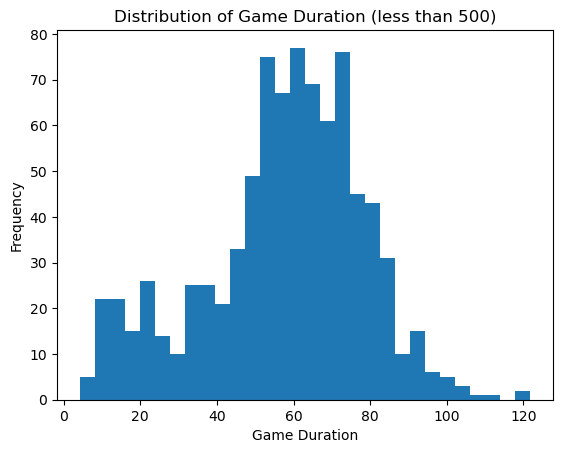

In [11]:
# Distribution of game duration
import matplotlib.pyplot as plt

plt.hist(game_df.loc[game_df["game_duration"] < 500, "game_duration"], bins=30)
plt.xlabel("Game Duration")
plt.ylabel("Frequency")
plt.title("Distribution of Game Duration (less than 500)")
plt.show()

In [12]:
# Distribution of games played per level
game_df.groupby("level").size()

level
1    493
2    244
3     76
4     33
5      9
dtype: int64

In [14]:
random_record_id = psychometrics_df["record_id"].sample(n=1).iloc[0]
psychometrics_df.loc[psychometrics_df["record_id"] == random_record_id]

,record_id,redcap_repeat_instrument,redcap_repeat_instance,redcap_survey_identifier,consent_timestamp,name,email,age,gender,gender_other,...,total_games_flow,fss_1,fss_2,fss_3,fss_4,fss_5,fss_6,fss_7,fss_8,flow_complete
94,73,NaN,NaN,NaN,2024-12-04 18:12:04,Rong Guang,guang.rong@helsinki.fi,39.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,73,flow,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,1.0,6.0,6.0,2.0,1.0,1.0,1.0,2.0,2.0
96,73,flow,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,1.0,7.0,7.0,1.0,1.0,1.0,1.0,1.0,2.0
97,73,flow,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,1.0,7.0,7.0,1.0,1.0,1.0,1.0,1.0,2.0
98,73,flow,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,3.0,7.0,7.0,1.0,1.0,1.0,1.0,1.0,2.0
99,73,flow,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.0,1.0,7.0,7.0,1.0,1.0,1.0,1.0,1.0,2.0
100,73,flow,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,1.0,7.0,7.0,1.0,1.0,1.0,1.0,1.0,2.0
101,73,flow,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.0,1.0,7.0,7.0,1.0,1.0,1.0,1.0,1.0,2.0
102,73,flow,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.0,1.0,7.0,7.0,1.0,1.0,1.0,1.0,1.0,2.0
103,73,flow,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.0,1.0,7.0,7.0,1.0,1.0,1.0,1.0,1.0,2.0


In [15]:
bisbas_df = psychometrics_df.loc[
    ~psychometrics_df["redcap_repeat_instrument"].isin(["flow", "sam"])
    & psychometrics_df["consent_timestamp"].notna()
    & (psychometrics_df["record_id"] > 60)
]

bisbas_df = bisbas_df.iloc[:, 5:34]

bisbas_df.describe()

,age,gender,gender_other,edu,experience,consent_answer,bis_1,bis_2,bis_3,bis_4,...,rew_4,rew_5,drive_1,drive_2,drive_3,drive_4,fun_1,fun_2,fun_3,fun_4
count,112.000000,112.000000,0.0,112.000000,105.000000,112.000000,111.000000,111.000000,111.000000,111.000000,...,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000
mean,28.705357,1.758929,NaN,4.241071,1.152381,0.991071,2.900901,3.153153,3.027027,3.279279,...,3.378378,3.117117,2.558559,2.567568,2.495495,1.981982,2.819820,2.900901,3.072072,2.531532
std,7.831144,0.700650,NaN,0.960907,0.361113,0.094491,0.762233,0.776919,0.768227,0.776603,...,0.661322,0.759650,0.794123,0.837980,0.761265,0.738327,0.875922,0.797211,0.709823,0.784159
min,20.000000,1.000000,NaN,2.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,23.750000,1.000000,NaN,4.000000,1.000000,1.000000,2.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,2.000000,2.000000,2.000000,1.500000,2.000000,2.000000,3.000000,2.000000
50%,26.500000,2.000000,NaN,4.000000,1.000000,1.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000
75%,31.000000,2.000000,NaN,5.000000,1.000000,1.000000,3.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,4.000000,3.000000
max,59.000000,4.000000,NaN,6.000000,2.000000,1.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
